# Project Code
## Data Acquisition

In [32]:
import requests
import pandas as pd
import numpy as np
# 1. API endpoint
url = "https://api.census.gov/data/2023/pep/charv"

# 2. Parameters
params = {
    "get": "NAME,STATE,YEAR,POP,AGE,SEX",
    "for": "state:*"
}

# 3. Send request
response = requests.get(url, params=params)

# 4. Parse JSON
data = response.json()

# 5. Convert to DataFrame
pop_df = pd.DataFrame(data[1:], columns=data[0])

pop_df.sample(5)


,NAME,STATE,YEAR,POP,AGE,SEX,state
7610,California,06,2020,256978,0900,1,06
16603,Florida,12,2022,702993,5054,1,12
33833,Maine,23,2022,7655,2400,1,23
55611,New Mexico,35,2020,8733,7400,2,35
59146,North Carolina,37,2020,20006,8300,2,37


In [33]:
pop_df.to_csv(
    "population_dataset.csv",
    index=False
)

In [34]:
pop_df.sample(5)

,NAME,STATE,YEAR,POP,AGE,SEX,state
51625,New Hampshire,33,2020,5937,0001,2,33
33178,Maine,23,2022,81000,1519,0,23
67934,Rhode Island,44,2023,11315,0900,0,44
84657,West Virginia,54,2021,3945,8100,1,54
83909,West Virginia,54,2023,22012,5500,0,54


In [35]:
print(pop_df.shape)
print(type(pop_df.AGE[0]))

(90480, 7)
<class 'str'>


In [36]:
def fetch_acs_median_income_state(year):
    """
    grab ACS 1-year meadian household income in past 12 months for all states.
    endpoint: https://api.census.gov/data/{year}/acs/acs1
    variable: B19013_001E
    """
    url = f"https://api.census.gov/data/{year}/acs/acs1"
    params = {
        "get": "NAME,B19013_001E",
        "for": "state:*",
    }

    r = requests.get(url, params=params, timeout=60)

    # raise error if not 200
    if r.status_code != 200:
        raise RuntimeError(f"HTTP {r.status_code}: {r.text[:300]}")

    data = r.json()
    df = pd.DataFrame(data[1:], columns=data[0])

    # clean
    df["YEAR"] = year
    df = df.rename(columns={"state": "STATE", "B19013_001E": "median_hh_income"})
    df["STATE"] = df["STATE"].astype(str).str.zfill(2)
    df["median_hh_income"] = pd.to_numeric(df["median_hh_income"], errors="coerce")

    return df[["STATE", "YEAR", "NAME", "median_hh_income"]]


years = [2021, 2022, 2023]
acs_income = pd.concat([fetch_acs_median_income_state(y) for y in years], ignore_index=True)

acs_income.head()


,STATE,YEAR,NAME,median_hh_income
0,01,2021,Alabama,53913
1,72,2021,Puerto Rico,22237
2,04,2021,Arizona,69056
3,05,2021,Arkansas,52528
4,06,2021,California,84907


In [37]:
acs_income.to_csv(
    "median_income_state.csv",
    index=False
)

In [38]:
print(len(acs_income.STATE.unique()))
print(acs_income.STATE.unique())


52
['01' '72' '04' '05' '06' '08' '09' '10' '11' '12' '13' '15' '16' '17'
 '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '44' '45' '46'
 '47' '48' '49' '50' '51' '53' '54' '55' '56' '02']


In [39]:
pop_df["STATE"] = pop_df["STATE"].astype(str).str.zfill(2)
acs_income["STATE"] = acs_income["STATE"].astype(str).str.zfill(2)

pop_df["YEAR"] = pop_df["YEAR"].astype(int)
acs_income["YEAR"] = acs_income["YEAR"].astype(int)

merged_df = pop_df.merge(
    acs_income[["STATE", "YEAR", "median_hh_income"]],
    on=["STATE", "YEAR"],
    how="left"
)

merged_df.to_csv(
    "merged_dataset.csv",
    index=False
)

In [40]:
merged_df.sample(5)

,NAME,STATE,YEAR,POP,AGE,SEX,state,median_hh_income
13959,District of Columbia,11,2023,647847,0499,0,11,108210.0
81245,Virginia,51,2020,254490,0509,2,51,NaN
45073,Missouri,29,2022,42249,5900,2,29,64811.0
41868,Mississippi,28,2022,170708,1417,0,28,52719.0
2639,Alaska,02,2023,4823,4400,1,02,86631.0


---

## Data Cleaning

In [41]:
print(merged_df.shape)

print(merged_df.columns)

print(merged_df.describe(include='all'))

(90480, 8)
Index(['NAME', 'STATE', 'YEAR', 'POP', 'AGE', 'SEX', 'state',
       'median_hh_income'],
      dtype='object')
           NAME  STATE          YEAR    POP    AGE    SEX  state  \
count     90480  90480  90480.000000  90480  90480  90480  90480   
unique       52     52           NaN  67557    116      3     52   
top     Alabama     01           NaN   5911   0000      0     01   
freq       1740   1740           NaN      9    780  30160   1740   
mean        NaN    NaN   2021.200000    NaN    NaN    NaN    NaN   
std         NaN    NaN      1.166197    NaN    NaN    NaN    NaN   
min         NaN    NaN   2020.000000    NaN    NaN    NaN    NaN   
25%         NaN    NaN   2020.000000    NaN    NaN    NaN    NaN   
50%         NaN    NaN   2021.000000    NaN    NaN    NaN    NaN   
75%         NaN    NaN   2022.000000    NaN    NaN    NaN    NaN   
max         NaN    NaN   2023.000000    NaN    NaN    NaN    NaN   

        median_hh_income  
count       54288.000000  
unique

In [42]:
merged_df = merged_df.rename(columns=({
    'NAME': 'State_name',
    'STATE': 'State_code',
    'YEAR': 'Year',
    'POP': 'Population',
    'AGE': 'Age',
    'SEX': 'Sex',
    'median_hh_income': 'Median_household_income'
}
))

# Drop duplicate 'state' column
if 'state' in merged_df.columns:
    merged_df = merged_df.drop(columns=['state'])

merged_df.head(5)

,State_name,State_code,Year,Population,Age,Sex,Median_household_income
0,Alabama,01,2020,5024294,0000,0,NaN
1,Alabama,01,2020,5031864,0000,0,NaN
2,Alabama,01,2021,5050380,0000,0,53913.0
3,Alabama,01,2022,5073903,0000,0,59674.0
4,Alabama,01,2023,5108468,0000,0,62212.0


In [43]:
# Alter data type
merged_df['Year'] = merged_df['Year'].astype(int)
merged_df['Population'] = pd.to_numeric(merged_df['Population'], errors='coerce')
merged_df['State_code'] = merged_df['State_code'].astype(str).str.zfill(2)
merged_df['Median_household_income'] = pd.to_numeric(merged_df['Median_household_income'], 
                                                     errors='coerce')
for col in ['State_name', 'Sex']:
    merged_df[col] = merged_df[col].astype('category')

# Drop rows with missing values in 'Median_household_income' and filter for years 2021 and later
# Since the income data is only for 2021-2023, we can safely filter for those years without losing any data.
merged_df_clean = merged_df[merged_df["Year"] >= 2021].copy()

In [44]:
merged_df_clean.head(5)

,State_name,State_code,Year,Population,Age,Sex,Median_household_income
2,Alabama,01,2021,5050380,0000,0,53913.0
3,Alabama,01,2022,5073903,0000,0,59674.0
4,Alabama,01,2023,5108468,0000,0,62212.0
7,Alabama,01,2021,56741,0001,0,53913.0
8,Alabama,01,2022,57666,0001,0,59674.0


In [45]:
# Missing value check
print(merged_df_clean.isna().sum())
merged_df_clean = merged_df_clean.reset_index(drop=True)
merged_df_clean.head(5)

State_name                 0
State_code                 0
Year                       0
Population                 0
Age                        0
Sex                        0
Median_household_income    0
dtype: int64


,State_name,State_code,Year,Population,Age,Sex,Median_household_income
0,Alabama,01,2021,5050380,0000,0,53913.0
1,Alabama,01,2022,5073903,0000,0,59674.0
2,Alabama,01,2023,5108468,0000,0,62212.0
3,Alabama,01,2021,56741,0001,0,53913.0
4,Alabama,01,2022,57666,0001,0,59674.0


In [46]:
# Remove duplicate rows

merged_df_clean = merged_df_clean.drop_duplicates()

print(merged_df_clean.duplicated().sum())

0


In [47]:
merged_df_clean.groupby(['State_code', 'Year'])['Median_household_income'].nunique().max()

1

The median household income variable is measured at the state–year level.
It represents the overall median household income of each state in a given year and is merged onto age- and sex-specific population records for analytical purposes. Therefore, income values are constant across age and sex groups within the same state and year.

---

## Exploratory Data Analysis (EDA)
### Data Structure Overview

The cleaned dataset contains 40,248 observations and 8 variables, representing demographic and economic information across U.S. states over multiple years.

#### Variable Composition

- 3 categorical variables 
    - State_name (52 unique states/regions)
    - Age_label (86 detailed age categories)
    - Age_group (8 broader age group categories)
- 5 numerical variables
    - State_code
    - Year
    - Population
    - Sex
    - Median_household_income

In [48]:
# ===============================
# Step 1: Import libraries
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Better plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# ===============================
# Step 2: Load data set
# ===============================

df = pd.read_csv("Cleaned_merged_dataset.csv")

# View first few rows
df.head(10)

,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group
0,Alabama,1,2021,5050380,0,53913.0,All ages,All ages
1,Alabama,1,2022,5073903,0,59674.0,All ages,All ages
2,Alabama,1,2023,5108468,0,62212.0,All ages,All ages
3,Alabama,1,2021,57503,0,53913.0,1,0-18
4,Alabama,1,2022,57244,0,59674.0,1,0-18
5,Alabama,1,2023,58419,0,62212.0,1,0-18
6,Alabama,1,2021,58637,0,53913.0,2,0-18
7,Alabama,1,2022,58117,0,59674.0,2,0-18
8,Alabama,1,2023,58006,0,62212.0,2,0-18
9,Alabama,1,2021,60349,0,53913.0,3,0-18


In [49]:
# Shape of data set
print("Dataset shape:", df.shape)

# Data types
df.info()

# Check unique values for categorical variables
for col in df.select_dtypes(include="object").columns:
    print(f"\nUnique values in {col}:")
    print(df[col].nunique())


Dataset shape: (40248, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40248 entries, 0 to 40247
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   State_name               40248 non-null  object 
 1   State_code               40248 non-null  int64  
 2   Year                     40248 non-null  int64  
 3   Population               40248 non-null  int64  
 4   Sex                      40248 non-null  int64  
 5   Median_household_income  40248 non-null  float64
 6   Age_label                40248 non-null  object 
 7   Age_group                40248 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 2.5+ MB

Unique values in State_name:
52

Unique values in Age_label:
86

Unique values in Age_group:
8


In [50]:
for col in df.select_dtypes(include="int64").columns:
    print(f"\nUnique values in {col}:")
    print(df[col].nunique())


Unique values in State_code:
52

Unique values in Year:
3

Unique values in Population:
32184

Unique values in Sex:
3


### Summary Statistics
#### Topic 1: Income Distribution and Inequality

In [51]:

income_df = df[df["Age_group"] == "All ages"].copy()

desc = income_df["Median_household_income"].describe()

cv = desc["std"] / desc["mean"]
iqr = desc["75%"] - desc["25%"]
range_val = desc["max"] - desc["min"]

# summary table
summary_table = pd.DataFrame({
    "Metric": [
        "Count",
        "Mean",
        "Standard Deviation",
        "Minimum",
        "25th Percentile",
        "Median",
        "75th Percentile",
        "Maximum",
        "Range",
        "Interquartile Range (IQR)",
        "Coefficient of Variation (CV)"
    ],
    "Value": [
        desc["count"],
        desc["mean"],
        desc["std"],
        desc["min"],
        desc["25%"],
        desc["50%"],
        desc["75%"],
        desc["max"],
        range_val,
        iqr,
        cv
    ]
})

summary_table


,Metric,Value
0,Count,468.000000
1,Mean,72802.288462
2,Standard Deviation,14203.555681
3,Minimum,22237.000000
4,25th Percentile,64800.000000
5,Median,71680.000000
6,75th Percentile,82194.000000
7,Maximum,108210.000000
8,Range,85973.000000
9,Interquartile Range (IQR),17394.000000


## Summary of Household Income Distribution Across States

- **Mean vs. Median**

  The mean median household income is **$72,802**,

  closely aligned with the median value of **$71,680**.

  This suggests a **relatively symmetric distribution**, with no extreme distortion from outliers.

- **Dispersion**

  - Standard deviation: **$14,203**

  - Coefficient of variation: **19.5%**
 
  These figures indicate **moderate income dispersion** across states. While meaningful differences exist, the inequality is not excessively polarized.

- **Range and Extremes**

  The income range spans from **$22,237**

  to **$108,210**, highlighting **substantial disparities** between the lowest- and highest-income states.

- **Interquartile Range (IQR)**

  An IQR of **$17,394** shows that the **middle 50% of states are clustered within a narrower band**, implying that extreme states contribute disproportionately to the overall variation.


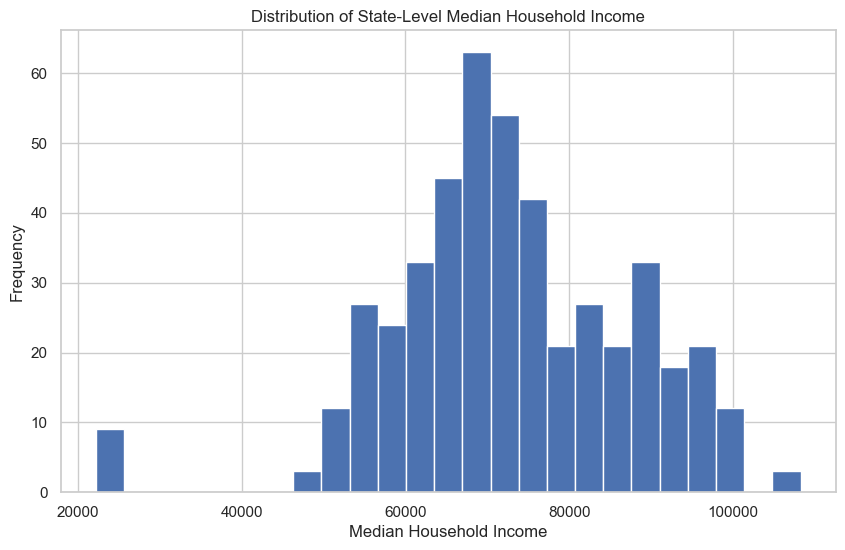

In [52]:
plt.figure()
plt.hist(income_df["Median_household_income"], bins=25)
plt.title("Distribution of State-Level Median Household Income")
plt.xlabel("Median Household Income")
plt.ylabel("Frequency")
plt.show()


#### Income Distribution Shape Analysis

The histogram illustrates a mildly left-skewed income distribution. While most states cluster between $60,000–$85,000, a small number of lower-income states extend the left tail toward $20,000–$40,000.

This visual pattern is consistent with the negative skewness value (−0.379), indicating that the distribution is slightly influenced by lower-income outliers. However, the overall shape remains relatively symmetric, as evidenced by the close proximity of the mean $72,802 and median $71,680.

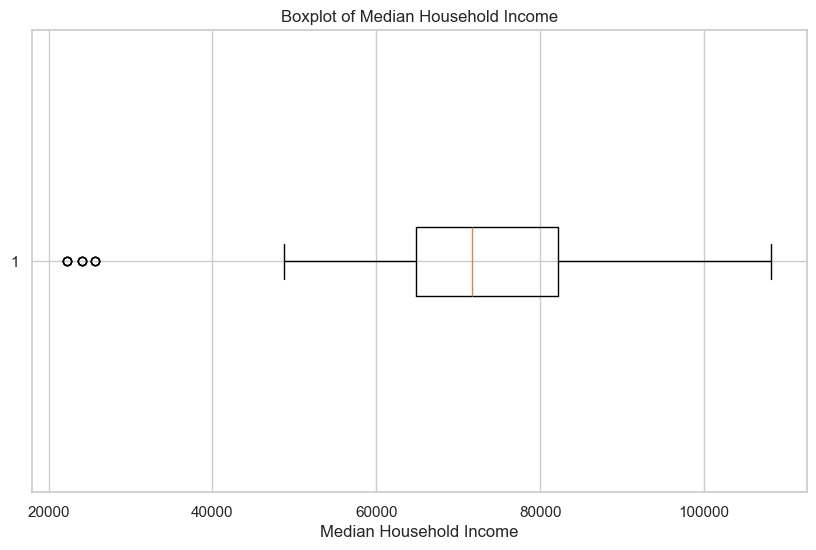

In [53]:
plt.figure()
plt.boxplot(income_df["Median_household_income"], vert=False)
plt.title("Boxplot of Median Household Income")
plt.xlabel("Median Household Income")
plt.show()


#### Income Boxplot Analysis

The boxplot of median household income reveals a moderately dispersed distribution with several notable low-income outliers. The median income lies near the center of the interquartile range, indicating a relatively balanced distribution among the middle 50% of state-year observations.

The left whisker extends further and is accompanied by a small number of distinct low-income outliers around the $20,000–$30,000 range. This visual pattern suggests that a few economically disadvantaged states contribute to a longer left tail in the income distribution.

In contrast, the right tail does not exhibit extreme high-income outliers, implying that overall income inequality is not driven by exceptionally wealthy states. This observation is consistent with the negative skewness (−0.379) and supports the conclusion that the income distribution is mildly left-skewed rather than heavily polarized.


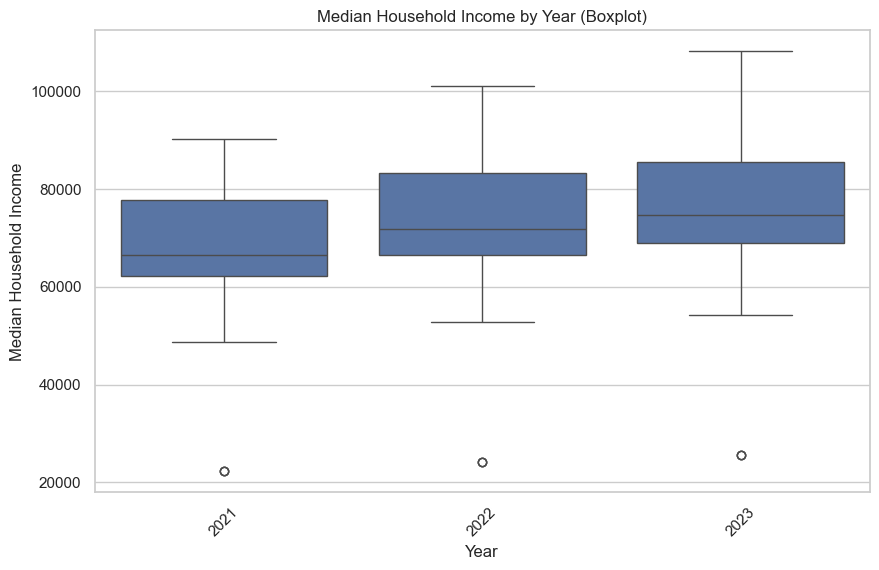

In [54]:
plt.figure(figsize=(10,6))
sns.boxplot(data=income_df, x="Year", y="Median_household_income")
plt.title("Median Household Income by Year (Boxplot)")
plt.xlabel("Year")
plt.ylabel("Median Household Income")
plt.xticks(rotation=45)
plt.show()

#### Income Boxplot Analysis / year

Figure X shows the distribution of median household income by year. The boxplots indicate that the entire income distribution shifts upward over time, with increasing medians from 2021 to 2023. While lower-income outliers persist, the interquartile range remains relatively stable, suggesting broad-based income growth rather than increased dispersion.

<Axes: xlabel='Year'>

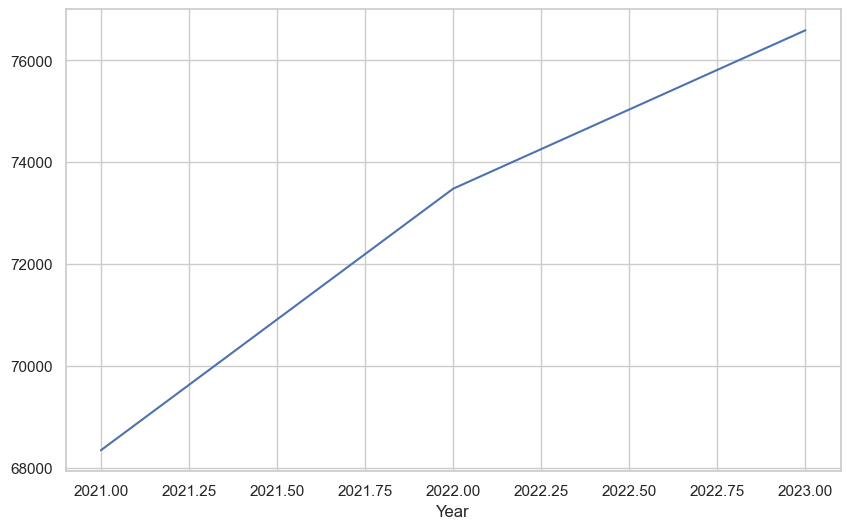

In [55]:
year_income = income_df.groupby("Year")["Median_household_income"].mean()

growth_rate = year_income.pct_change().mean()

year_income.plot()


#### Trend in Median Household Income Over Time

The line plot shows a clear upward trend in median household income from 2021 to 2023.  
Income increases steadily across the three years, rising from approximately **$68,000** in 2021 to about **$76,500** in 2023.

The largest year-over-year increase occurs between **2021 and 2022**, suggesting a relatively rapid income growth during this period.  

From **2022 to 2023**, income continues to rise but at a slightly slower pace, indicating a moderation in growth rather than a reversal.

Overall, the consistent upward trajectory suggests sustained improvement in household income levels over time, with no evidence of short-term declines or volatility during the observed period.


### Relationship of State Size to Income

In [56]:
state_level = income_df.groupby("State_name").agg({
    "Median_household_income": "mean",
    "Population": "mean"
})

state_level.corr()

,Median_household_income,Population
Median_household_income,1.000000,0.135451
Population,0.135451,1.000000


The correlation between state population and median household income is 0.135, indicating a weak positive linear association. While larger states tend to have slightly higher incomes, the magnitude is small, suggesting that population size alone does not meaningfully explain income differences across states.

In [57]:
income_df["Median_household_income"].skew()

np.float64(-0.3790292861711357)

The skewness of −0.379 indicates a mild left-skew in the income distribution. This suggests the presence of a small number of relatively low-income states that extend the lower tail of the distribution.

However, the magnitude of skewness is moderate, implying that the distribution remains largely balanced and not heavily distorted by extreme outliers.

The moderate negative skew further confirms that the overall inequality is not driven by extreme high-income states but rather by a limited number of lower-income observations.


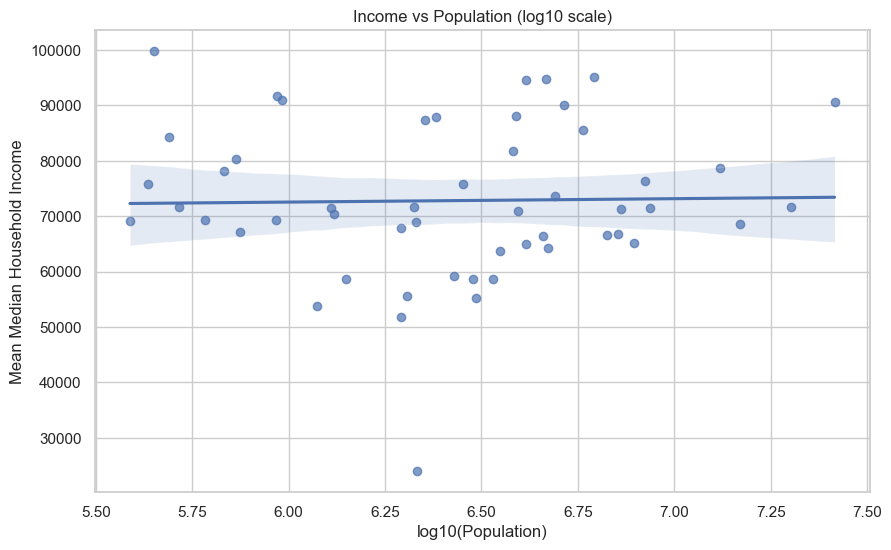

In [58]:
state_level = income_df.groupby("State_name").agg(
    Median_household_income=("Median_household_income", "mean"),
    Population=("Population", "mean")
).reset_index()

state_level["log_pop"] = np.log10(state_level["Population"])

plt.figure(figsize=(10,6))
sns.regplot(data=state_level, x="log_pop", y="Median_household_income", scatter_kws={"alpha":0.7})
plt.title("Income vs Population (log10 scale)")
plt.xlabel("log10(Population)")
plt.ylabel("Mean Median Household Income")
plt.show()

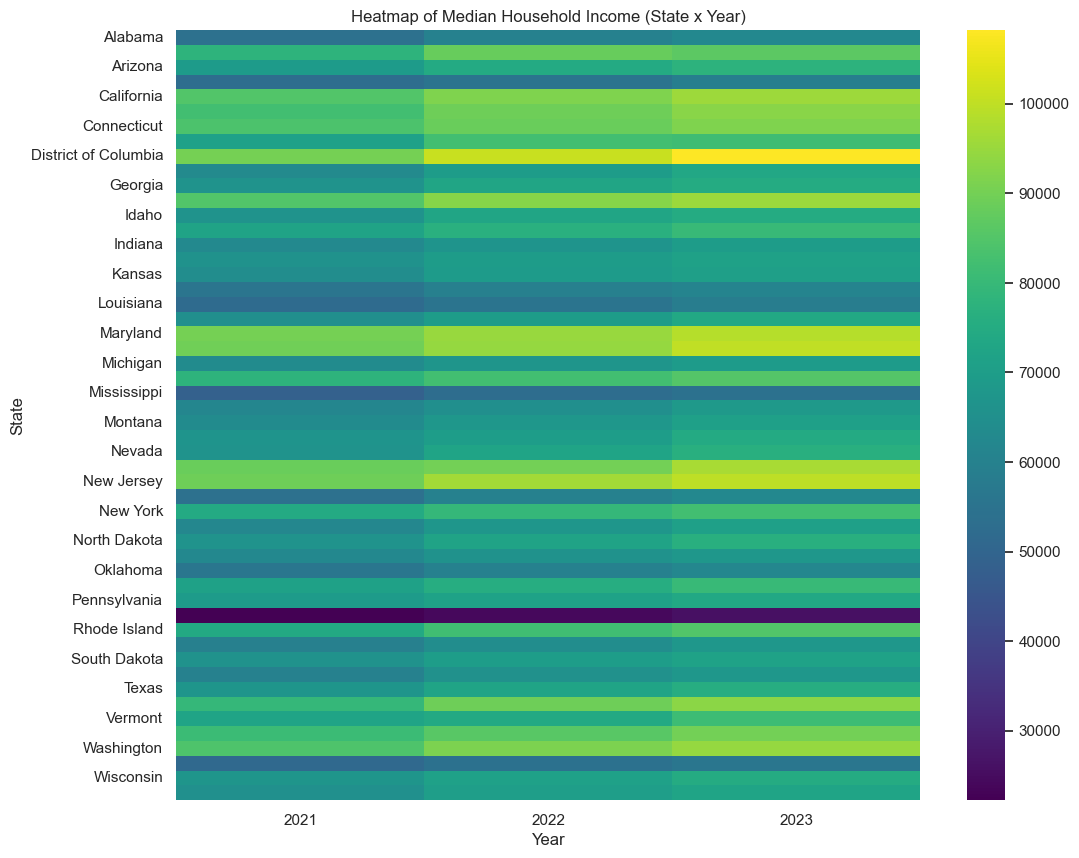

In [59]:
pivot = income_df.pivot_table(
    index="State_name",
    columns="Year",
    values="Median_household_income",
    aggfunc="mean"
)

plt.figure(figsize=(12,10))
sns.heatmap(pivot, cmap="viridis")  
plt.title("Heatmap of Median Household Income (State x Year)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()


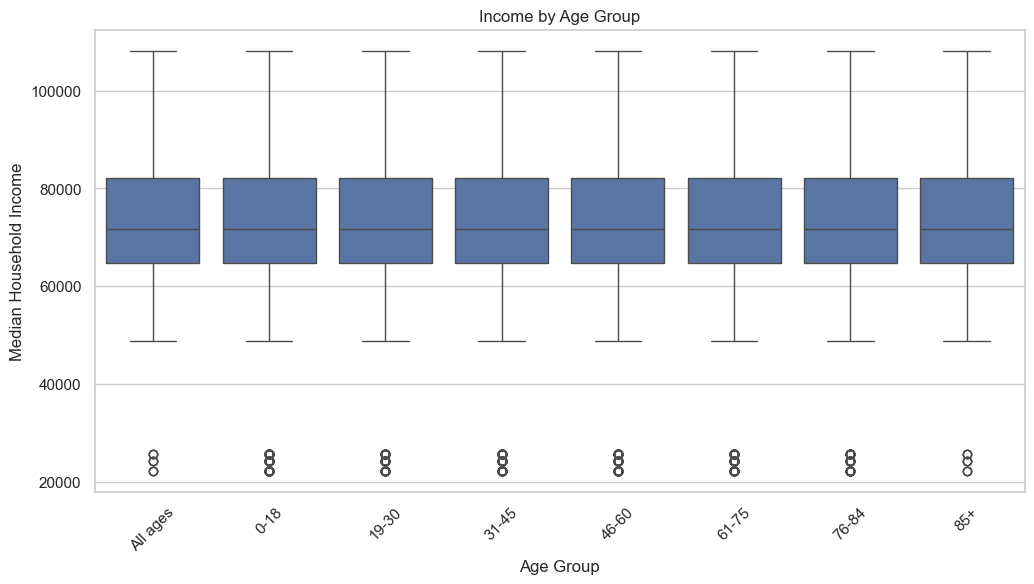

In [60]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Age_group", y="Median_household_income")
plt.title("Income by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Median Household Income")
plt.xticks(rotation=45)
plt.show()

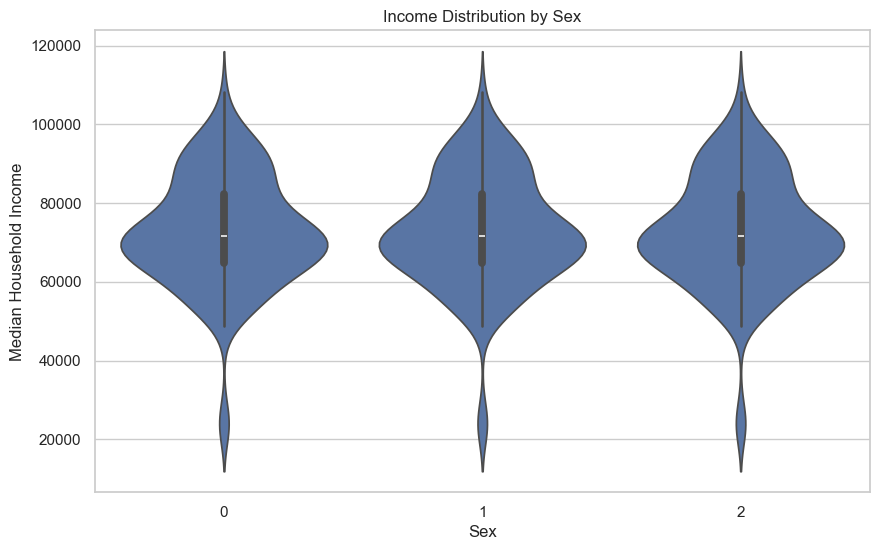

In [61]:
plt.figure(figsize=(10,6))
sns.violinplot(data=income_df, x="Sex", y="Median_household_income")
plt.title("Income Distribution by Sex")
plt.xlabel("Sex")
plt.ylabel("Median Household Income")
plt.show()

---

## Data preprocessing & Feature Engineering

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
for col in merged_df_clean.columns:
    print(f"{col}: {merged_df_clean[col].dtype}")

State_name: category
State_code: object
Year: int64
Population: int64
Age: object
Sex: category
Median_household_income: float64


In [63]:
merged_df_clean.Age.unique()

array(['0000', '0001', '0100', '0200', '0300', '0400', '0401', '0499',
       '0500', '0509', '0513', '0600', '0700', '0800', '0900', '1000',
       '1014', '1100', '1200', '1300', '1400', '1417', '1500', '1519',
       '1544', '1600', '1699', '1700', '1800', '1824', '1864', '1899',
       '1900', '2000', '2024', '2100', '2200', '2300', '2400', '2500',
       '2529', '2544', '2600', '2700', '2800', '2900', '3000', '3034',
       '3100', '3200', '3300', '3400', '3500', '3539', '3600', '3700',
       '3800', '3900', '4000', '4044', '4100', '4200', '4300', '4400',
       '4500', '4549', '4564', '4600', '4700', '4800', '4900', '5000',
       '5054', '5100', '5200', '5300', '5400', '5500', '5559', '5600',
       '5700', '5800', '5900', '5999', '6000', '6064', '6100', '6200',
       '6300', '6400', '6500', '6569', '6599', '6600', '6700', '6800',
       '6900', '7000', '7074', '7100', '7200', '7300', '7400', '7500',
       '7579', '7600', '7700', '7800', '7900', '8000', '8084', '8100',
      

In [64]:

merged_df_clean["Age"] = merged_df_clean["Age"].astype(str)
def is_valid_age_code(age_code):
    # keep all ages population
    if age_code == "0000":
        return True
    
    # keep 85+ group
    if age_code == "8599":
        return True
    
    # find single age groups that end with "00" (e.g., "0100", "0200", ..., "8400")
    if age_code.endswith("00") and age_code != "0000":
        return True
    
    return False
merged_df_clean = merged_df_clean[merged_df_clean["Age"].apply(is_valid_age_code)].copy()
merged_df_clean["Age"].unique()

array(['0000', '0100', '0200', '0300', '0400', '0500', '0600', '0700',
       '0800', '0900', '1000', '1100', '1200', '1300', '1400', '1500',
       '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300',
       '2400', '2500', '2600', '2700', '2800', '2900', '3000', '3100',
       '3200', '3300', '3400', '3500', '3600', '3700', '3800', '3900',
       '4000', '4100', '4200', '4300', '4400', '4500', '4600', '4700',
       '4800', '4900', '5000', '5100', '5200', '5300', '5400', '5500',
       '5600', '5700', '5800', '5900', '6000', '6100', '6200', '6300',
       '6400', '6500', '6600', '6700', '6800', '6900', '7000', '7100',
       '7200', '7300', '7400', '7500', '7600', '7700', '7800', '7900',
       '8000', '8100', '8200', '8300', '8400', '8599'], dtype=object)

In [65]:
mask = merged_df_clean["Age"].eq("0000") | merged_df_clean["Age"].eq("8599") | merged_df_clean["Age"].str.match(r"^\d{2}00$")
merged_df_clean = merged_df_clean[mask].copy()

def age_code_to_year(code: str):
    if code == "0000":
        return np.nan          
    if code == "8599":
        return 85              # use 85 represent 85+
    return int(code[:2])

merged_df_clean["Age_year"] = merged_df_clean["Age"].apply(age_code_to_year)

# create a new column "Age_label" for better readability
merged_df_clean["Age_label"] = np.where(merged_df_clean["Age"].eq("0000"), "All ages",
                   np.where(merged_df_clean["Age"].eq("8599"), "85+",
                            merged_df_clean["Age_year"].astype("Int64").astype(str)))

merged_df_clean.Age_label.unique()

array(['All ages', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85+'],
      dtype=object)

In [66]:
merged_df_clean.head(5)

,State_name,State_code,Year,Population,Age,Sex,Median_household_income,Age_year,Age_label
0,Alabama,01,2021,5050380,0000,0,53913.0,NaN,All ages
1,Alabama,01,2022,5073903,0000,0,59674.0,NaN,All ages
2,Alabama,01,2023,5108468,0000,0,62212.0,NaN,All ages
6,Alabama,01,2021,57503,0100,0,53913.0,1.0,1
7,Alabama,01,2022,57244,0100,0,59674.0,1.0,1


In [67]:
merged_df_clean.drop(columns=["Age"], inplace=True)

In [68]:
merged_df_clean.head(5)

,State_name,State_code,Year,Population,Sex,Median_household_income,Age_year,Age_label
0,Alabama,01,2021,5050380,0,53913.0,NaN,All ages
1,Alabama,01,2022,5073903,0,59674.0,NaN,All ages
2,Alabama,01,2023,5108468,0,62212.0,NaN,All ages
6,Alabama,01,2021,57503,0,53913.0,1.0,1
7,Alabama,01,2022,57244,0,59674.0,1.0,1


In [69]:
for col in merged_df_clean.columns:
    print(f"{col}: {merged_df_clean[col].dtype}")

State_name: category
State_code: object
Year: int64
Population: int64
Sex: category
Median_household_income: float64
Age_year: float64
Age_label: object


In [70]:
# 1) create Age_group column
merged_df_clean["Age_group"] = pd.NA

# 2) keep All ages / 85+ as separate groups
is_all = merged_df_clean["Age_label"].astype(str).str.strip().str.lower().eq("all ages")
is_85p = merged_df_clean["Age_label"].astype(str).str.strip().str.lower().eq("85+")
merged_df_clean.loc[is_all, "Age_group"] = "All ages"
merged_df_clean.loc[is_85p, "Age_group"] = "85+"

# 3) Create age groups: 0-18, 19-30, 31-45, 46-60, 61-75, 76-84, 85+
bins = [-0.1, 18, 30, 45, 60, 75, 84, 200]
labels = ["0-18", "19-30", "31-45", "46-60", "61-75", "76-84", "85+"]

mask_other = (~is_all) & (~is_85p) & (merged_df_clean["Age_year"].notna())

merged_df_clean.loc[mask_other, "Age_group"] = pd.cut(
    merged_df_clean.loc[mask_other, "Age_year"].astype(float),
    bins=bins,
    labels=labels
).astype(str)

# 4) check results
merged_df_clean["Age_group"].value_counts(dropna=False)


Age_group
0-18        8424
31-45       7020
46-60       7020
61-75       7020
19-30       5616
76-84       4212
All ages     468
85+          468
Name: count, dtype: int64

In [71]:
merged_df_clean.drop(columns=["Age_year"], inplace=True)

In [72]:
merged_df_clean.head(5)

,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group
0,Alabama,01,2021,5050380,0,53913.0,All ages,All ages
1,Alabama,01,2022,5073903,0,59674.0,All ages,All ages
2,Alabama,01,2023,5108468,0,62212.0,All ages,All ages
6,Alabama,01,2021,57503,0,53913.0,1,0-18
7,Alabama,01,2022,57244,0,59674.0,1,0-18




To improve interpretability and reduce excessive granularity, we transformed single-year age values into broader age categories (e.g., 0–18, 19–30, 31–45, 46–60, 61–75, 76–84, 85+), while retaining the All ages category for aggregate-level analysis.

Single-year age data can be overly detailed and may introduce noise in cross-sectional comparisons. By grouping ages into meaningful life-stage intervals, we achieve:

- More stable population aggregation  
- Clearer demographic interpretation  
- Reduced sparsity in age-specific observations  
- Improved usability in visualization and comparative analysis  

This feature engineering step enhances structural clarity in demographic analysis while preserving essential population patterns across states and years.


In [73]:
# Data type standardization
merged_df_clean['Year'] = merged_df_clean['Year'].astype(int)
merged_df_clean["State_name"] = merged_df_clean["State_name"].astype("category")
merged_df_clean["Age_group"] = merged_df_clean["Age_group"].astype("category")

merged_df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 40248 entries, 0 to 54287
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   State_name               40248 non-null  category
 1   State_code               40248 non-null  object  
 2   Year                     40248 non-null  int64   
 3   Population               40248 non-null  int64   
 4   Sex                      40248 non-null  category
 5   Median_household_income  40248 non-null  float64 
 6   Age_label                40248 non-null  object  
 7   Age_group                40248 non-null  category
dtypes: category(3), float64(1), int64(2), object(2)
memory usage: 2.0+ MB


Year is saved as integer type to preserve temporal ordering. Also, State_name and Age_group are converted to categorical types in order to ensure appropriate grouping behaviors. The standardization step makes sure that the structure is consistent before advanced transformations. 

In [74]:
# Within-state income deviation
income_df = merged_df_clean[merged_df_clean['Age_group'] == 'All ages'].copy()

income_df["state_mean_income"] = (
    income_df.groupby("State_name")["Median_household_income"]
    .transform("mean")
)

income_df["income_within_state"] = (
    income_df["Median_household_income"]
    - income_df["state_mean_income"]
)

print(income_df['income_within_state'].mean())

income_df.head(5)

-5.596890472448789e-13


/var/folders/kn/zjhb2btj0hn5513h5_jjb6vw0000gn/T/ipykernel_11510/138944621.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_df.groupby("State_name")["Median_household_income"]


,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group,state_mean_income,income_within_state
0,Alabama,01,2021,5050380,0,53913.0,All ages,All ages,58599.666667,-4686.666667
1,Alabama,01,2022,5073903,0,59674.0,All ages,All ages,58599.666667,1074.333333
2,Alabama,01,2023,5108468,0,62212.0,All ages,All ages,58599.666667,3612.333333
348,Alabama,01,2021,2452912,1,53913.0,All ages,All ages,58599.666667,-4686.666667
349,Alabama,01,2022,2463660,1,59674.0,All ages,All ages,58599.666667,1074.333333


This variable captures how each state's income in a given year deviates from its own long-run average. 

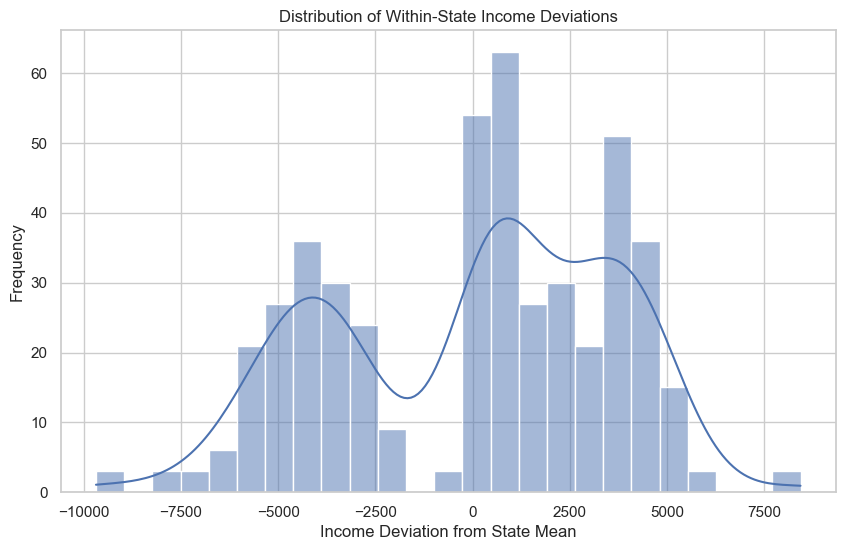

In [75]:
plt.figure()
sns.histplot(income_df["income_within_state"], bins=25, kde=True)
plt.title("Distribution of Within-State Income Deviations")
plt.xlabel("Income Deviation from State Mean")
plt.ylabel("Frequency")
plt.show()

After examining the distribution, it is obvious that:

- The mean of this variable is approximately 0.

- The distribution exhibits mild bimodality, suggesting heterogeneous performance across states.

- Deviations range roughly between −8,000 and +8,000, indicating substantial intra-state variability across years.

- The presence of both positive and negative tails reflects asymmetric temporal adjustments across states.

<Axes: xlabel='Year', ylabel='income_within_state'>

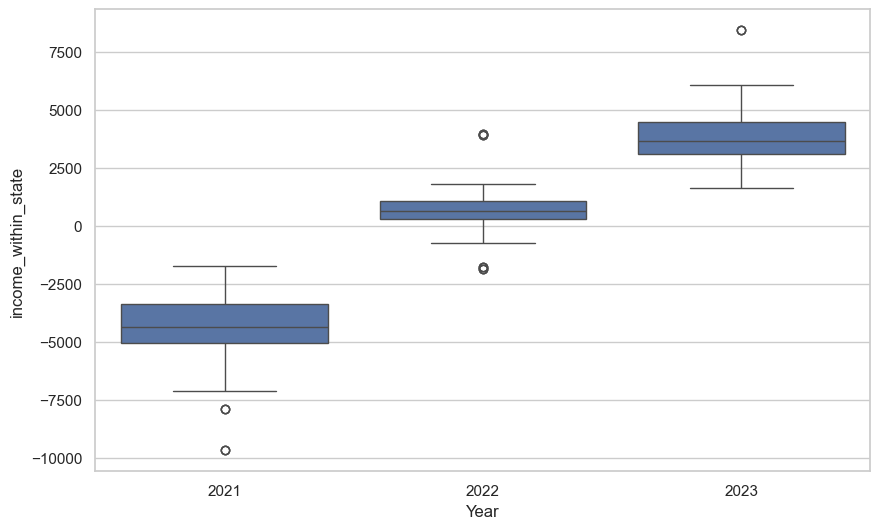

In [76]:
sns.boxplot(
    data=income_df,
    x="Year",
    y="income_within_state"
)

2021: mostly negative; 2022: positive shift; 2023: stabilization

In [77]:
# Income growth rate
income_df["income_growth_rate"] = (
    income_df.groupby("State_name")["Median_household_income"]
    .pct_change()
)

income_df.head(5)

/var/folders/kn/zjhb2btj0hn5513h5_jjb6vw0000gn/T/ipykernel_11510/3401012025.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_df.groupby("State_name")["Median_household_income"]


,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group,state_mean_income,income_within_state,income_growth_rate
0,Alabama,01,2021,5050380,0,53913.0,All ages,All ages,58599.666667,-4686.666667,NaN
1,Alabama,01,2022,5073903,0,59674.0,All ages,All ages,58599.666667,1074.333333,0.106857
2,Alabama,01,2023,5108468,0,62212.0,All ages,All ages,58599.666667,3612.333333,0.042531
348,Alabama,01,2021,2452912,1,53913.0,All ages,All ages,58599.666667,-4686.666667,-0.133399
349,Alabama,01,2022,2463660,1,59674.0,All ages,All ages,58599.666667,1074.333333,0.106857


This feature measures year-over-year percentage change in median income. In this way, we are asking how fast is a state growing economically. 

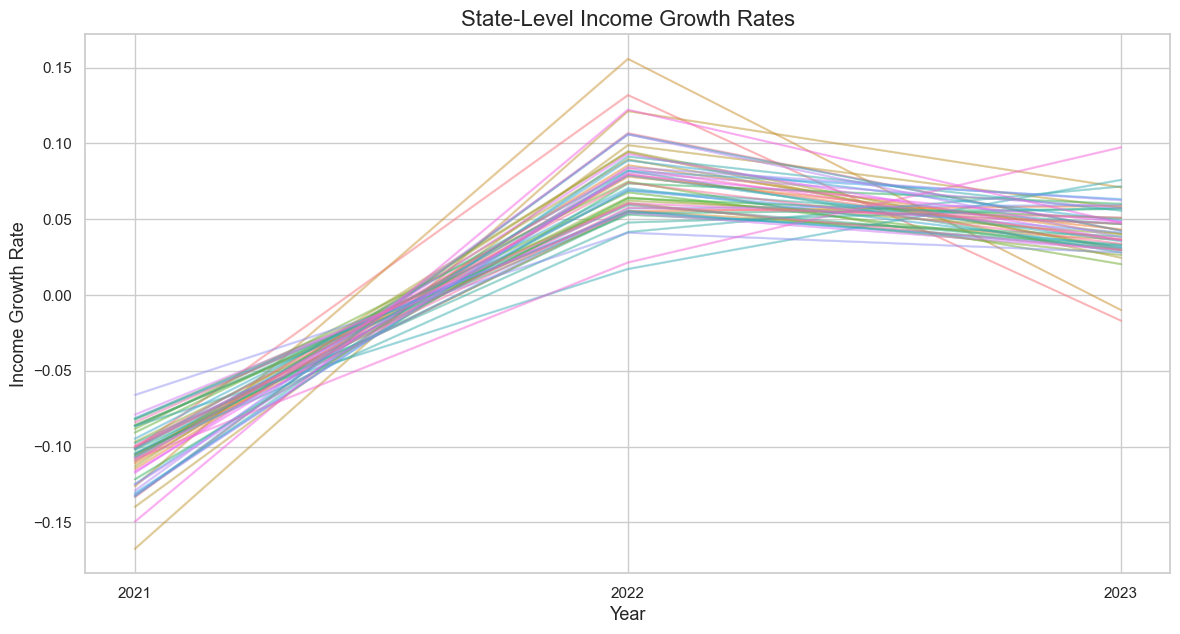

In [78]:
plt.figure(figsize=(14, 7))   

sns.lineplot(
    data=income_df,
    x="Year",
    y="income_growth_rate",
    hue="State_name",
    legend=False,
    alpha=0.4   
)

plt.title("State-Level Income Growth Rates", fontsize=16)
plt.xlabel("Year", fontsize=13)
plt.ylabel("Income Growth Rate", fontsize=13)

plt.xticks([2021, 2022, 2023])  
plt.show()


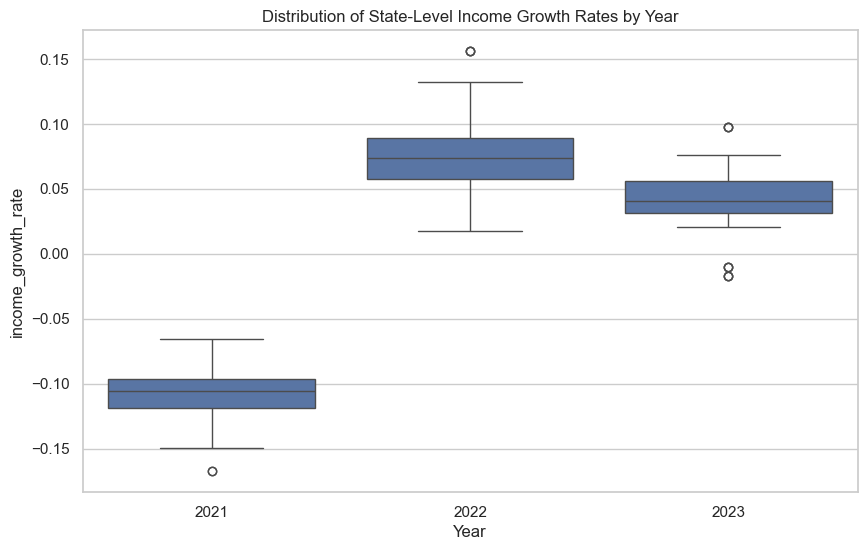

In [79]:
plt.figure(figsize=(10,6))

sns.boxplot(
    data=income_df,
    x="Year",
    y="income_growth_rate"
)

plt.title("Distribution of State-Level Income Growth Rates by Year")
plt.show()

We can easily see that growth rates were strongest between 2021 and 2022 and slowed slightly in 2023 for many states. In addition, variability across states is non-negligible. A few states show much higher volatility than the national average.

In [80]:
# Income volatility
state_stats = (
    income_df.groupby("State_name")["Median_household_income"]
    .agg(["mean","std"])
    .reset_index()
)

state_stats["cv"] = state_stats["std"] / state_stats["mean"]
state_stats_sorted = state_stats.sort_values("cv", ascending=False)
state_stats_sorted.head()

/var/folders/kn/zjhb2btj0hn5513h5_jjb6vw0000gn/T/ipykernel_11510/319484637.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_df.groupby("State_name")["Median_household_income"]


,State_name,mean,std,cv
8,District of Columbia,99775.000000,7903.038134,0.079209
45,Utah,87346.000000,6202.456711,0.071010
7,Delaware,78208.666667,5349.845302,0.068405
9,Florida,68558.666667,4472.920550,0.065242
0,Alabama,58599.666667,3682.797272,0.062847


Coefficient of variation measures dispersion relative to the mean. Unlike raw standard deviation, it controls for income scale differences.

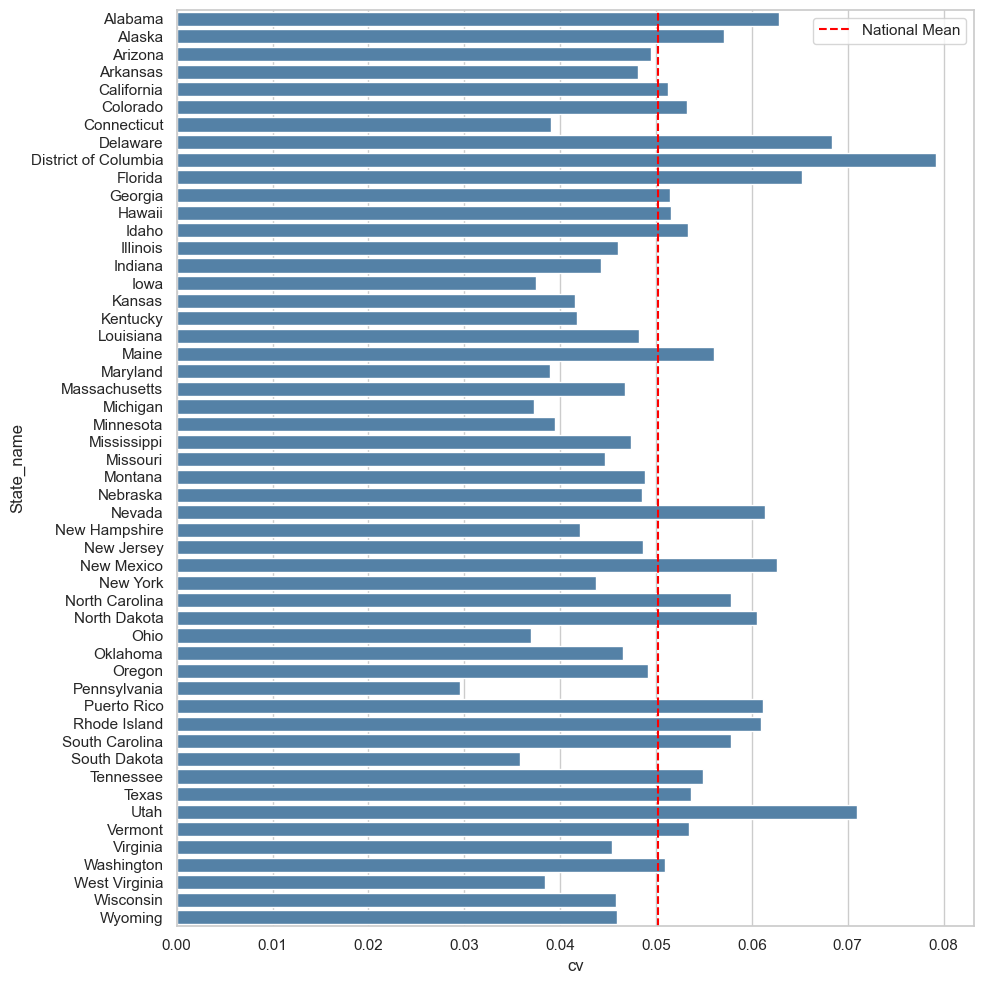

In [81]:
national_mean = state_stats["cv"].mean()

plt.figure(figsize=(10,10))

sns.barplot(
    data=state_stats_sorted,
    x="cv",
    y="State_name",
    color="steelblue"
)

plt.axvline(national_mean, color="red", linestyle="--", label="National Mean")

plt.legend()
plt.tight_layout()
plt.show()


The volatility ranking indicates that: first, high-income states do not necessarily exhibit higher relative volatility; second, some mid-income states display disproportionate fluctuation; third, several states show remarkably stable income trajectories across years.

In [82]:
national_mean = income_df.groupby("Year")["Median_household_income"].transform("mean")

income_df["income_relative_to_national"] = (
    income_df["Median_household_income"] - national_mean
)

income_df.sample(5)

,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group,state_mean_income,income_within_state,income_growth_rate,income_relative_to_national
35844,North Dakota,38,2021,399472,1,66519.0,All ages,All ages,71671.333333,-5152.333333,-0.130755,-1820.788462
36194,North Dakota,38,2023,381838,2,76525.0,All ages,All ages,71671.333333,4853.666667,0.063290,-64.519231
39325,Oregon,41,2022,2126890,2,75657.0,All ages,All ages,75793.000000,-136.000000,0.057223,2179.442308
13573,Illinois,17,2022,12582515,0,76708.0,All ages,All ages,76406.333333,301.666667,0.062364,3230.442308
26796,Missouri,29,2021,3123390,2,61847.0,All ages,All ages,65067.666667,-3220.666667,-0.097717,-6492.788462


This variable captures the difference between a state's income and the national average in the same year. It removes overall national trends and highlights each state's relative economic standing.

In [84]:
income_df["income_zscore_within_year"] = (
    income_df.groupby("Year")["Median_household_income"]
    .transform(lambda x: (x - x.mean()) / x.std())
)
income_df.sample(5)

,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group,state_mean_income,income_within_state,income_growth_rate,income_relative_to_national,income_zscore_within_year
23665,Michigan,26,2022,5061136,2,66986.0,All ages,All ages,66555.666667,430.333333,0.054931,-6491.557692,-0.465252
25058,Mississippi,28,2023,2939690,0,54203.0,All ages,All ages,51879.333333,2323.666667,0.028149,-22386.519231,-1.536145
25753,Mississippi,28,2022,1512732,2,52719.0,All ages,All ages,51879.333333,839.666667,0.082170,-20758.557692,-1.487772
28190,Nebraska,31,2023,1978379,0,74590.0,All ages,All ages,70334.666667,4255.333333,0.071742,-1999.519231,-0.137205
4176,California,06,2021,39145060,0,84907.0,All ages,All ages,90659.666667,-5752.666667,NaN,16567.211538,1.286519


This standardized income measure expresses each state's income in standard deviation units relative to the yearly national distribution, enabling scale-free comparison and outlier detection. Together, these two relative and standardized transformations improve interpretability, enhance comparability across states, and reduce scale effects, thereby increasing the analytical usefulness of the dataset.

---